In [46]:
import numpy as np
import jax.numpy as jnp
import jax

from scipy.optimize import minimize
# from jax.scipy.optimize import minimize

import scoobpsf.jax_scoob as jscoob
import scoobpsf.jax_dm as jdm
from scoobpsf.imshows import *

from importlib import reload

Nact = 34
Nacts = 952
act_spacing = 300*u.um

pupil_diam = 10.2*u.mm
npix = 256

pupil_pxscl = pupil_diam.to_value(u.m)/npix

wavelength= 650*u.nm

from importlib import reload



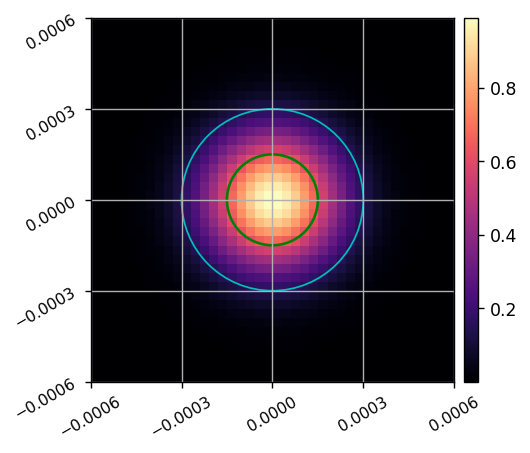

/home/kianmilani/miniconda3/envs/cpu311env/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


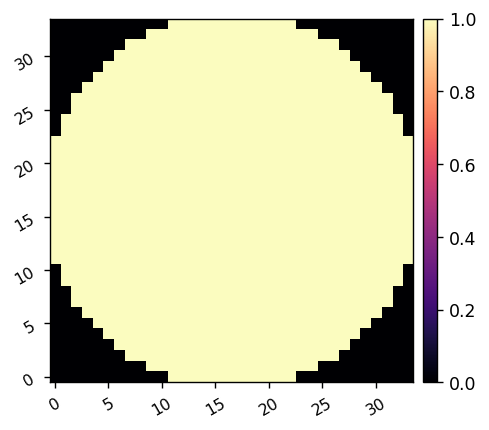

952


In [47]:
reload(jdm)
inf_fun, inf_sampling, inf_pixelscale = jdm.make_gaussian_inf_fun(sampling=10, Nacts_per_inf=4, plot=True)
inf_pixelscale = inf_pixelscale.to_value(u.m/u.pix)
dm_mask = jdm.make_dm_mask(plot=True)
print(dm_mask.sum())


In [31]:
inf_matrix = jdm.make_inf_matrix(inf_fun, inf_sampling, dm_mask)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


Jax platform: cpu
Jax device: cpu


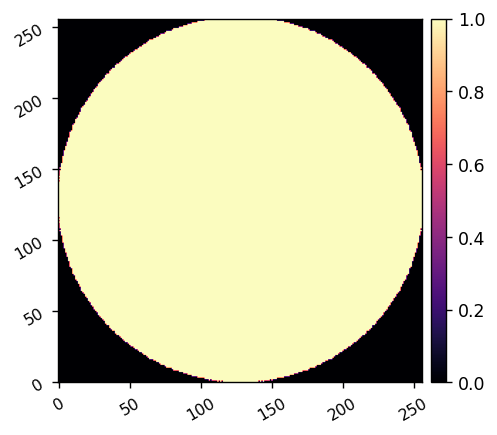

Oversampling > 2x suggested for reliable results in Fresnel propagation.


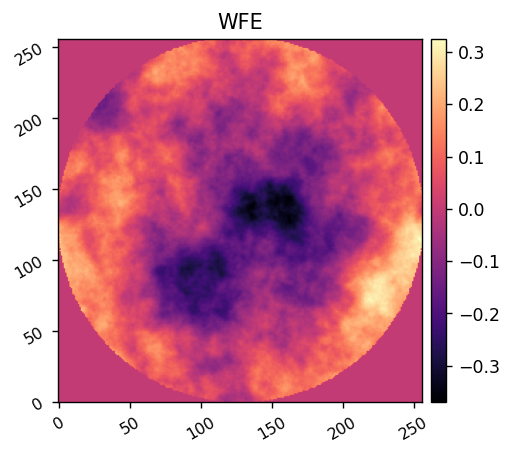

In [68]:
reload(jscoob)
oversample = 1
pupil = jscoob.make_pupil(pupil_diam, npix, oversample)>0
imshow1(pupil)

WFE = jscoob.generate_wfe(diam=pupil_diam,
                        #   amp_rms=0*u.nm, opd_rms=0*u.nm,
                          amp_rms=0.0, amp_index=3.2, opd_rms=10*u.nm, opd_index=3.5,
                          npix=npix, oversample=oversample,)

WFE = jnp.angle(WFE)
imshow1(WFE, 'WFE')




In [20]:
WFE[pupil].shape

(52019,)

In [49]:
actuators = jnp.zeros(Nacts)
# actuators = jnp.array(np.random.randn(Nacts))*2e-9
actuators.shape

(952,)

In [69]:
def cost_fun(del_actuators):
    '''
    acts: the actuator vector we want to find an optimal solution for
    I_tar_ratio: ratio for the desired target irradiance based on current integrated irradiance
    eta_00: parameter that Scott understands more
    E_ab: current electric-field estimate
    '''
    delsurf = inf_matrix.dot(del_actuators).reshape(int(jnp.sqrt(inf_matrix.shape[0])), int(jnp.sqrt(inf_matrix.shape[0])))
    delphi = 4*np.pi/wavelength.to_value(u.m) * jdm.interp_arr(delsurf, inf_pixelscale, pupil_pxscl)
    delphi = jdm.pad_or_crop(delphi, npix)
    total = WFE[pupil] + delphi[pupil]
    J = total.dot(total)/822.08109784

    return J

In [70]:
del_actuators = jnp.zeros(Nacts)
cost_fun(del_actuators)

Array(0.98551441, dtype=float64)

0.9855144109344821 (952,)


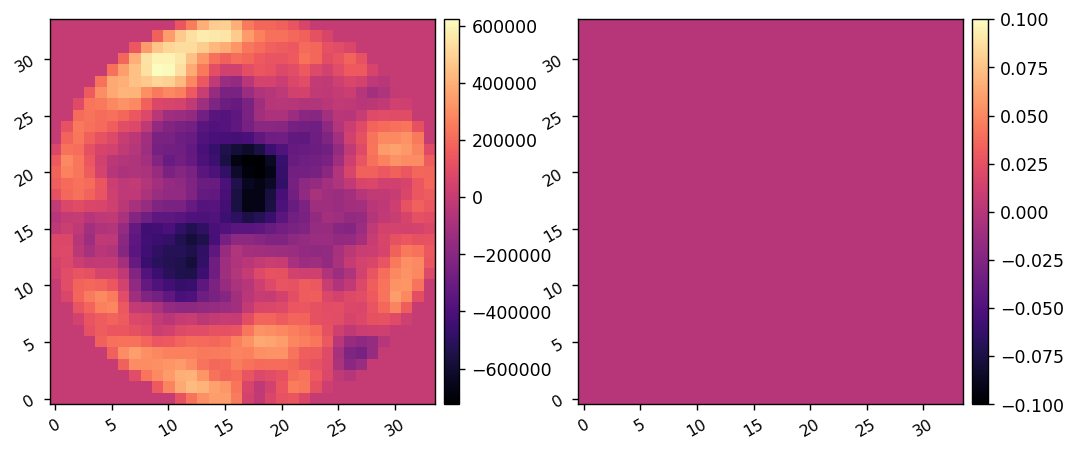

In [71]:
del_actuators = jnp.zeros(Nacts)
# del_actuators = jnp.array(np.random.randn(Nacts))*0.5e-9
command = jdm.map_actuators_to_command(del_actuators, dm_mask)
value_and_grad_of_cost = jax.value_and_grad(cost_fun)

val_and_grad = value_and_grad_of_cost(del_actuators)
print(val_and_grad[0], val_and_grad[1].shape)
grad_command = jdm.map_actuators_to_command(val_and_grad[1], dm_mask)
imshow2(grad_command/2, command)

In [53]:
del_acts0 = jnp.zeros(Nacts)

In [72]:
from scipy.optimize import minimize
res = minimize(value_and_grad_of_cost, jac=True, x0=del_acts0, 
                method='L-BFGS-B', 
                tol=1e-5,
                options={'disp':True},
                )

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85514D-01    |proj g|=  1.45018D+06

At iterate    1    f=  3.72222D-02    |proj g|=  2.45956D+05

At iterate    2    f=  2.21820D-02    |proj g|=  1.04561D+05

At iterate    3    f=  1.51388D-02    |proj g|=  4.89357D+04

At iterate    4    f=  1.32488D-02    |proj g|=  2.89738D+04

At iterate    5    f=  1.24700D-02    |proj g|=  2.45185D+04

At iterate    6    f=  1.20887D-02    |proj g|=  1.50342D+04

At iterate    7    f=  1.19361D-02    |proj g|=  1.48382D+04

At iterate    8    f=  1.17637D-02    |proj g|=  1.28635D+04

At iterate    9    f=  1.16883D-02    |proj g|=  1.07995D+04

At iterate   10    f=  1.16206D-02    |proj g|=  8.57147D+03

At iterate   11    f=  1.15841D-02    |proj g|=  6.57844D+03

At iterate   12    f=  1.15619D-02    |proj g|=  4.64928D+03

At iterate   13    f=  1.1

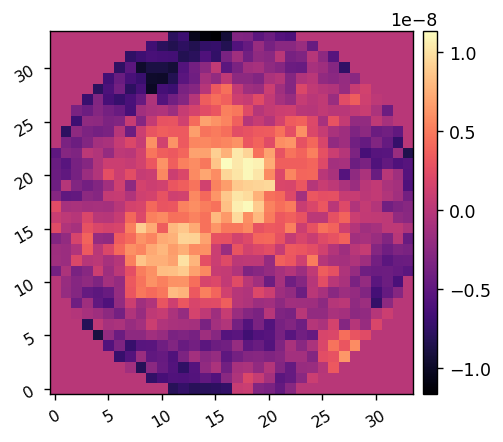

In [73]:
acts = res.x
command = jdm.map_actuators_to_command(res.x, dm_mask)
imshow1(command)


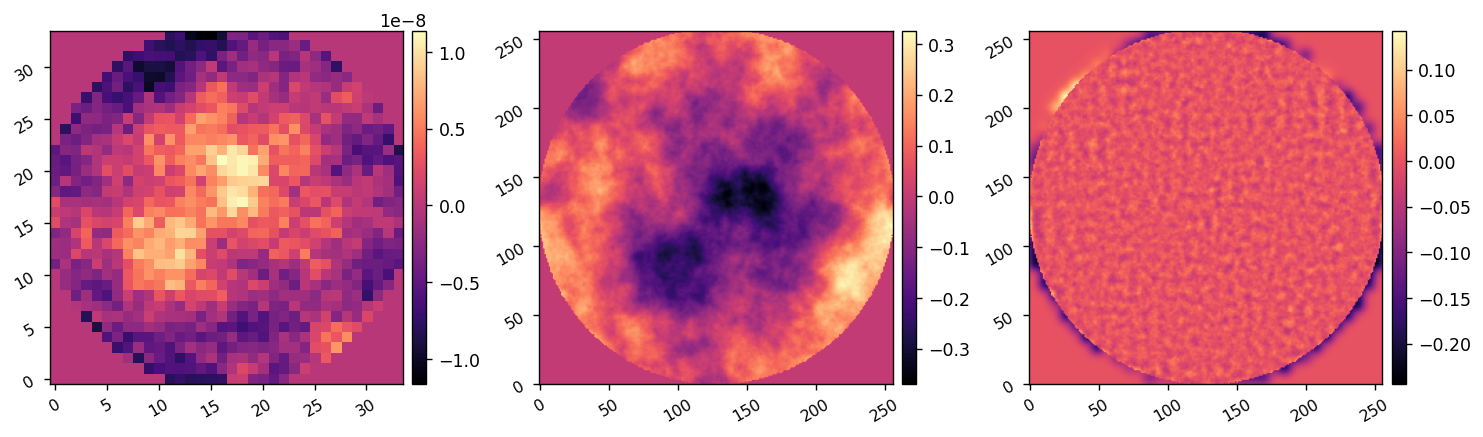

In [74]:
acts = res.x
command = jdm.map_actuators_to_command(res.x, dm_mask)

delsurf = inf_matrix.dot(acts).reshape(int(jnp.sqrt(inf_matrix.shape[0])), int(jnp.sqrt(inf_matrix.shape[0])))
delphi = 4*np.pi/wavelength.to_value(u.m) * jdm.interp_arr(delsurf, inf_pixelscale, pupil_pxscl)
delphi = jdm.pad_or_crop(delphi, npix)
total = WFE + delphi
imshow3(command, WFE, total)